# Principal Component Analysis Exploration

We begin PCA by importing the necessary libraries for PCA and one-hot encoding the categorical variables in our CCRB dataset. PCA is a mathematical technique that only operates on numerical data, so this is a crucial preprocessing step. Then, we needed to standardize our present data. This is another important step since PCA is sensitive to the scale of the variables. Without standardization, variables with larger variance will dominate the principal components, regardless of their true importance. Standardizing the data before running PCA ensures that all features are given equal importance, and the principal components are based on the actual variations in the data, rather than the scale of the features. Finally, we have to check for Nan and infinite values once the standardization is complete. `StandardScaler` performs a mathematical operation that scales the data by subtracting the mean of each feature and dividing by its standard deviation. If a feature has a standard deviation of zero, this will result in dividing by zero, which produces an infinite value.

In [1]:
# import libraries for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load dataset
ccrb = pd.read_csv("CCRB Complaint Database Raw 04.20.2021.csv")
ccrb = ccrb.drop(columns = ["AsOfDate", "AllegationID", "LastName", "FirstName", "ShieldNo", "ComplaintID",
                            "PenaltyRec", "NYPDDisposition", "PenaltyDesc", "LocationType", "ReceivedDate",
                            "CloseDate", "IncidentRank", "CurrentRank", "BoardCat", "OfficerID", "LastActive"])

# lowercase all column names and strings in column names
ccrb.columns= ccrb.columns.str.lower()
for column in list(ccrb.columns):
    if type(ccrb[column][0]) == str:
        ccrb[column] = ccrb[column].str.lower()
    
# binarize the CCRBDisposition column between (0) unsubstantiated and (1) substantiated
# if substantiated, switch to substantiated; if anything else, then unsubstantiated
ccrbDispositionList = list(ccrb["ccrbdisposition"])
for i in range(len(ccrbDispositionList)):
    if "substantiated" in ccrbDispositionList[i] and "unsubstantiated" not in ccrbDispositionList[i]:
        ccrbDispositionList[i] = 1
    else:
        ccrbDispositionList[i] = 0
ccrb["ccrbdisposition"] = ccrbDispositionList
ccrb = ccrb.drop(columns = ["incidentdate"])
ccrb = ccrb.drop(ccrb[ccrb["daysonforce"] < 0].index)
ccrb = ccrb.drop(ccrb[ccrb["impactedage"] < 0].index)
ccrb = ccrb.drop(ccrb[ccrb["impactedage"] > 116].index)

/var/folders/l2/xv51rkfn63jbsv89xfpxyyw40000gn/T/ipykernel_1499/1533389708.py:9: DtypeWarning: Columns (10,11,12,18,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ccrb = pd.read_csv("CCRB Complaint Database Raw 04.20.2021.csv")


In [2]:
# select the columns to one-hot encode
categorical_cols = ['officerrace', 'officergender', 'currentranklong', 'currentcommand',
                    'incidentranklong', 'incidentcommand', 'status', 'fadotype',
                    'allegation', 'ccrbdisposition', 'contactreason', 'contactoutcome',
                    'incidentprecinct', 'impactedrace', 'impactedgender']

# create a new data frame with one-hot encoded categorical columns
ccrb_onehot = pd.get_dummies(ccrb, columns=categorical_cols)

# standardize data (important since PCA is sensitive to scale of variables)
scaler = StandardScaler()
ccrb_std = scaler.fit_transform(ccrb_onehot)

# check for NaN and infinite values
print(np.argwhere(np.isnan(ccrb_std)))
print(np.argwhere(np.isinf(ccrb_std)))

[[     6      1]
 [     7      1]
 [    38      1]
 ...
 [279401      1]
 [279402      1]
 [279403      1]]
[]


In order to PCA to run, we must drop all missing and infinite values from our standardized dataset.

In [3]:
# remove rows with missing values after data standardization
ccrb_std = ccrb_std[~np.isnan(ccrb_std).any(axis=1)]

Before we run the PCA algorithm on our standardized dataset, we can see that the dataset currently as a shape of (156413, 1727). We can decrease this tremendously with PCA.

In [4]:
# standardized data before dimentionality reduction
ccrb_std.shape

(156413, 1727)

Now, we can fit the PCA algorithm to our clean, standardized data and plot the cumulative expected variance ratio (CEVR) in order to determine the optimal number of principal components. This plot shows the proportion of the total variance in the data explained by each principal component. As shown below, the range of principal components from 1250 to 1500 is the optimal range we can use on our dataset without losing much of the original variance in our data.

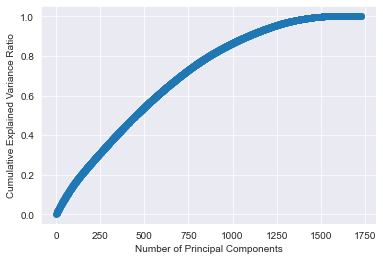

In [5]:
# create instance of PCA class and fit it to standardized data
pca = PCA()
pca.fit(ccrb_std)

# plot the explained variance ratio to determine optimal number of principal components
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

We chose to incorporate the lower end of the "elbow point" in our plot. While 1500 principal components would represent our original data without losing any information, using all the principal components may not always be the best option, as it can lead to overfitting and poor generalization to new data. It's recommended to select a smaller number of principal components that explain most of the variance in the data, while still keeping the overall number of dimensions low. Therefore, we chose 1250 principal components as our optimal number.

In [6]:
# select the optimal number of principal components based on the explained variance ratio
n_components = 1250

# create a new instance of PCA with the optimal number of components
pca = PCA(n_components=n_components)

# fit the PCA to the standardized data
pca.fit(ccrb_std)

# apply the PCA transformation to the original dataset
ccrb_pca = pca.transform(ccrb_std)

# convert the numpy array to a pandas dataframe
ccrb_pca_df = pd.DataFrame(ccrb_pca, columns=['PC{}'.format(i) for i in range(1, n_components + 1)])

Our new dataframe is now (156413, 1250), which is an excellent improvement from our original shape of (156413, 1727).

In [7]:
ccrb_pca_df.shape

(156413, 1250)

In [8]:
ccrb_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC1241,PC1242,PC1243,PC1244,PC1245,PC1246,PC1247,PC1248,PC1249,PC1250
0,3.432578,1.901380,0.806995,-0.627474,-0.460719,-0.054986,-0.194638,-0.310963,-0.213856,0.258294,...,0.110507,-0.772121,0.461982,-0.049147,0.302498,0.603389,-0.437954,0.277316,-0.132184,-0.303969
1,1.974037,-1.731652,3.098930,1.459270,1.710861,-0.304135,0.201441,-0.119725,0.312730,-0.213211,...,-0.214800,-0.650855,-0.258251,-0.483728,-0.272994,-0.468212,-0.160684,0.335170,0.091589,-0.267518
2,2.288147,-1.906507,2.804625,1.886332,2.179817,-0.344474,0.161765,-0.120861,0.299091,-0.204900,...,-0.193663,-0.663837,-0.161855,-0.473914,-0.330433,-0.544840,-0.043042,0.203647,0.046822,-0.312700
3,2.151354,-0.440804,-0.809708,1.580581,1.103921,-0.089014,-0.285871,-0.051141,-0.204562,0.101992,...,-0.094019,-0.024444,0.059710,-0.090757,-0.050932,-0.123846,0.085653,0.049150,0.083185,-0.018335
4,1.931198,-0.264607,-0.674787,1.510230,1.141764,-0.088301,-0.292642,-0.058770,-0.199963,0.090368,...,-0.096882,-0.022312,-0.007695,-0.095664,-0.017443,-0.103552,0.031579,0.125927,0.097500,-0.013294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156408,-0.008772,-1.216193,-0.403700,0.216191,1.030664,-0.002482,-0.021378,-0.006415,0.030042,-0.019041,...,-0.387800,0.232375,0.182256,0.291902,-0.339813,-0.787532,0.015067,-0.325502,-0.184134,-0.045522
156409,-0.459564,-0.785143,0.452146,0.238683,0.641741,0.027676,-0.016482,-0.031548,0.036358,-0.022674,...,0.134420,0.262283,0.123140,0.653146,0.099076,-0.356695,-0.520696,-0.252355,0.216438,0.485481
156410,-1.059525,0.358593,-2.005754,-1.408777,0.407033,0.091342,0.198869,0.053506,-0.069824,0.085933,...,0.128527,0.316561,0.126817,0.660284,0.114873,-0.406202,-0.573233,-0.283119,0.174175,0.508602
156411,0.154940,1.841185,0.291021,-1.100357,0.438152,0.047121,-0.102990,0.120073,-0.139580,-0.037268,...,1.529442,-0.992422,1.473601,0.606894,0.563340,-0.145436,0.439037,-0.843807,-0.188134,0.412223


When using PCA, the new column names generated by the transformation will correspond to the principal components themselves (i.e., "PC1", "PC2", etc.). These new columns represent linear combinations of the original features that capture the most variance in the data.

In general, it's not possible to directly interpret the principal components in terms of the original features, since they are not just simple combinations of the original features. However, it is possible to examine the loadings of each feature on each principal component to gain some insight into which original features are most strongly associated with each principal component. This process is done below. Each row in `loadings_df` corresponds to a principal component and each column corresponds to an original feature, with the values in the cells representing the weight of each feature on each principal component. We can use this data frame to interpret the relationship between the original features and the principal components.

In [9]:
# create a new data frame with the loadings of each feature on each principal component
loadings_df = pd.DataFrame(pca.components_, columns=ccrb_onehot.columns)

# display the loadings
loadings_df

,daysonforce,impactedage,officerrace_american indian,officerrace_asian,officerrace_black,officerrace_hispanic,officerrace_white,officergender_female,officergender_male,currentranklong_captain,...,impactedrace_other race,impactedrace_refused,impactedrace_unknown,impactedrace_white,impactedgender_female,impactedgender_gender non-conforming,impactedgender_male,impactedgender_not described,impactedgender_transman (ftm),impactedgender_transwoman (mtf)
0,-0.191209,0.033772,-0.007371,0.053717,0.026509,0.049270,-0.078895,0.095129,-0.095129,-0.013783,...,0.042522,0.019892,0.036836,0.053319,0.072855,0.004350,-0.051506,0.007575,0.005308,0.007129
1,0.153030,0.111578,0.002864,-0.009802,-0.052168,-0.108791,0.133054,0.018318,-0.018318,0.002527,...,0.057115,0.025299,-0.001069,0.299000,0.108934,0.005163,-0.076521,0.006319,-0.003220,0.015677
2,0.117182,-0.000567,-0.002890,-0.016298,-0.017840,0.010375,0.009540,0.009425,-0.009425,-0.008233,...,0.013078,-0.016735,0.011783,0.116667,0.105167,0.006059,-0.073131,-0.000587,0.001596,-0.009389
3,-0.061101,-0.017018,0.002884,0.011350,-0.000457,-0.131421,0.108543,-0.045210,0.045210,0.002161,...,-0.010640,-0.001717,0.014423,0.069449,-0.010960,0.006946,0.006519,0.002290,0.005562,0.022424
4,0.032867,0.015862,0.012843,0.022567,0.082849,-0.121131,0.036369,-0.000995,0.000995,0.007977,...,0.009812,-0.014121,-0.013309,-0.011619,0.030495,0.007801,-0.020135,-0.004896,0.002588,-0.030218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0.017626,-0.006613,0.000668,-0.007822,-0.010115,0.006087,0.004602,-0.002413,0.002413,-0.026911,...,0.004723,0.000188,-0.005030,0.003842,0.003025,0.002164,-0.003952,0.009373,0.000515,0.000364
1246,-0.046964,0.012878,-0.001378,-0.012839,0.016422,0.007178,-0.013238,0.002456,-0.002456,-0.010281,...,-0.000548,-0.000675,0.005853,0.002586,0.000209,-0.001533,-0.000676,-0.005311,0.000762,0.000615
1247,0.066682,0.012191,-0.006016,0.012780,-0.004655,-0.002460,0.001363,0.001637,-0.001637,-0.017610,...,-0.002381,0.005367,0.001644,-0.004758,0.000735,-0.000966,0.001600,-0.006100,-0.001018,0.003203
1248,0.012433,-0.004374,0.001311,0.000630,-0.008890,-0.001704,0.007444,0.000865,-0.000865,-0.035342,...,-0.000948,-0.002573,-0.003099,-0.014486,0.001652,-0.000970,-0.000432,-0.007334,-0.001701,0.000512
